In [25]:
from rl_ood import *
import scipy.integrate as integrate

In [2]:
path = Path.cwd()
device = 'cpu'
path

PosixPath('/Users/gardille/development/RL-OOD-detection')

In [3]:
default_values, values = get_cartpole_values()
env = instanciate_cartpole(default_values)

### Create dataset

In [107]:
env = instanciate_cartpole(default_values)


def create_dataset(env, nb_steps = 10000, memory_size = 10):
    
    obs_limits = get_space_limits(env.observation_space)  
    act_limits = get_space_limits(env.action_space)
    env = Memory(env, memory_size)
    state_size = env.obs_limits[0].shape[0]
    action_size = env.act_limits[0].shape[0]
    
    input_size = memory_size*(state_size+action_size)

    X = np.zeros((nb_steps, input_size))
    y = np.zeros((nb_steps, state_size))

    
    observation = env.reset()

    pbar = trange(nb_steps)
    for t in pbar:

        action = env.action_space.sample()
        previous_obs = observation
        observation, reward, terminated, info = env.step(action)
        history = env.get_history(True).reshape(input_size)

        real_diff = np.array(observation-previous_obs)

        X[t] = history
        y[t] = real_diff

        if terminated:
            observation = env.reset()

    return X, y


In [108]:
X_pred, y_pred = create_dataset(env)
os.makedirs(path/'Dataset'/'pred', exist_ok=True)
np.save(path/'Dataset'/'pred'/'X.npy', X_pred)
np.save(path/'Dataset'/'pred'/'y.npy', y_pred)

100%|██████████| 10000/10000 [00:00<00:00, 54702.80it/s]


In [6]:

from sklearn.neighbors import KNeighborsRegressor

pred_model = MultiOutputRegressor(KNeighborsRegressor()).fit(X_pred, y_pred)

In [7]:
pred_model

MultiOutputRegressor(estimator=KNeighborsRegressor())

In [8]:
X_conf, y_conf = create_dataset(nb_steps=10000)
os.makedirs(path/'Dataset'/'conf', exist_ok=True)
np.save(path/'Dataset'/'conf'/'X.npy', X_conf)
np.save(path/'Dataset'/'conf'/'y.npy', y_conf)

100%|██████████| 10000/10000 [00:00<00:00, 55038.09it/s]


In [9]:
losses = pred_model.predict(X_conf) - y_conf
conf_model = MultiOutputRegressor(KNeighborsRegressor()).fit(X_conf, losses)

In [10]:
losses.mean()

8.666548999026417e-05

In [14]:
losses.max()

0.34508994221687317

In [15]:
from scipy import stats

def normal_test(X):
    # X est suppose de variance 1, et on test si son esperance est de 0
    #print('Variance: ', np.var(X))
    if len(X.shape) > 1:
        return np.array([normal_test(X[:,i]) for i in range(X.shape[1])])

    n = len(X)
    X = X / np.std(X)
    t = - np.abs(X.mean() * np.sqrt(n))
    p_value = 2.0 * stats.norm.cdf(t)
    return p_value

def corrected_test(X, std):
    # X est suppose de variance 1, et on test si son esperance est de 0
    #print('Variance: ', np.var(X))
    if len(X.shape) > 1:
        return np.array([corrected_test(X[:,i], std[:,i]) for i in range(X.shape[1])])

    n = len(X)
    X = X / std
    t = - np.abs(X.mean() * np.sqrt(n))
    p_value = 2.0 * stats.norm.cdf(t)
    return p_value
    
def evol_test(serie, saving_path,stat_threshold=1.0, p_value_threshold=0.05, Student=True):
    if Student:
        test_res = [stats.ttest_1samp(serie[:i], 0.0).pvalue for i in range(2,serie.shape[0])]
    else:
        test_res = [z_test(serie[:i]) for i in range(2,serie.shape[0])]
    test_res = np.array(test_res)
    plt.figure(figsize=(8, 4))
    #plt.ylim((-3.0, 3.0))
 
    plt.plot(test_res, label=np.arange(4)) #, label=['statistic', 'p-value'])
    plt.xlabel('Number of examples')
    plt.ylabel('P_value')
    plt.axhline(0, color='black', ls='-', lw=0.5)
    plt.axhline(0.05, color='magenta', ls='--', lw=0.5)
    plt.axhline(0.01, color='darkviolet', ls='--', lw=0.5)
    plt.axhline(stat_threshold, color='blue', ls='--', lw=0.5)
    plt.axhline(-stat_threshold, color='blue', ls='--', lw=0.5)
    plt.legend()
    #plt.legend(prop={'size': 'medium'}, ncol=2)
    plt.savefig(saving_path, bbox_inches="tight")
    plt.title('Evolution of the response of the statistical test')
    

def compare_test(series, saving_path,labels, stat_threshold=1.0, p_value_threshold=0.05, start_from=1):
    n = min([len(serie) for serie in series])
    test_res = [[z_test(serie[:i]) for i in serie.index[start_from:n]] for serie in series]
    print(len(test_res))
    
    absci = np.arange(start_from, n)
    plt.figure(figsize=(6, 3), dpi=300)
    plt.ylim((0, 1.2))

    plt.plot(absci, np.array(test_res).T, label=labels)
    plt.xlabel('Number of examples')
    plt.ylabel('P-value')
    
    plt.text(start_from - 2*n/10, 0.05,'0.05', color='magenta', fontsize='x-small')
    plt.text(start_from - 2*n/10, 0.00,'0.01', color='darkviolet', fontsize='x-small')
    
    
    plt.axhline(0, color='black', ls='-', lw=0.5)
    plt.axhline(0.05, color='magenta', ls='--', lw=0.5)
    plt.axhline(0.01, color='darkviolet', ls='--', lw=0.5)
    plt.axhline(stat_threshold, color='black', ls='--', lw=0.5)
    #plt.axhline(-stat_threshold, color='blue', ls='--', lw=0.5)
    plt.legend(prop={'size': 'medium'}, ncol=2)
    plt.savefig(saving_path, bbox_inches="tight")
    plt.title('Evolution of the p_value of the statistical tests')
    
    
def compare_all_test(series, saving_path, colors, linestyles, labels, start_from=1, log_scale=False, use_student=False):
    n = min([len(serie) for serie in series])
    
    if use_student:
        test_res = [[stats.ttest_1samp(serie[:i], 0.0).pvalue for i in serie.index[start_from:n]] for serie in series]
    else:
        test_res = [[z_test(serie[:i]) for i in serie.index[start_from:n]] for serie in series]
        
    print(np.array(test_res).shape)
    absci = np.arange(start_from, n)
    plt.figure(figsize=(6, 3), dpi=300)
    
    if log_scale:
        plt.yscale("log")
        plt.ylim((np.amin(test_res)/2, 5))
        
    else:
        plt.ylim((0, 1.2))
        plt.text(start_from - 2*n/10, 0.05,'0.05', color='magenta', fontsize='x-small')
        plt.text(start_from - 2*n/10, 0.00,'0.01', color='darkviolet', fontsize='x-small')

    for res, color, label, ls in zip(np.array(test_res), colors, labels, linestyles):
        plt.plot(absci, res, color=color, label=label, ls=ls)
    plt.xlabel('Number of examples')
    plt.ylabel('P-value')
    
    
    
    plt.axhline(0, color='black', ls='-', lw=0.5)
    plt.axhline(0.05, color='magenta', ls='--', lw=0.5)
    plt.axhline(0.01, color='darkviolet', ls='--', lw=0.5)
    plt.axhline(1.0, color='black', ls='--', lw=0.5)
    #plt.axhline(-stat_threshold, color='blue', ls='--', lw=0.5)
    
    
    
    plt.legend(prop={'size': 'medium'}, ncol=2)
    plt.savefig(saving_path, bbox_inches="tight")
    plt.title('Evolution of the p_value of the statistical tests')
    plt.show()
    return np.array(test_res)
    
    
def ratio_tests(series_list, stat_threshold=1.0, p_value_threshold=0.05, start_from=1):
    n = min([len(serie) for serie in series])
    assert start_from < n
    
    test_res_list = [[np.array([z_test(serie[:i]) for i in serie.index[start_from:n]]) for serie in series] for series in series_list]
    #test_res_2 = [np.array([z_test(serie[:i]) for i in serie.index[50:n]]) for serie in series_2]
    
    #ratio_1 = test_res_1[1] / test_res_1[0]
    ratios = [test_res[1] / test_res[0] for test_res in test_res_list]

    
    absci = np.arange(start_from, n)
    plt.figure(figsize=(6, 3), dpi=150)
    plt.ylim((0, 1.2))

    #for res, color in zip(np.array(test_res), colors):
    #plt.plot(absci, ratio_1) #, color=color)
    for ratio in ratios:
        plt.plot(absci, ratio) #, color=color)
    #plt.title('Evolution of the p_value of the statistical tests')
    plt.xlabel('Number of examples')
    plt.ylabel('P-value')
    
    plt.text(start_from - 2*n/10, 0.05,'0.05', color='magenta', fontsize='x-small')
    plt.text(start_from - 2*n/10, 0.00,'0.01', color='darkviolet', fontsize='x-small')
    
    
    plt.axhline(0, color='black', ls='-', lw=0.5)
    plt.axhline(0.05, color='magenta', ls='--', lw=0.5)
    plt.axhline(0.01, color='darkviolet', ls='--', lw=0.5)
    plt.axhline(stat_threshold, color='black', ls='--', lw=0.5)
    #plt.axhline(-stat_threshold, color='blue', ls='--', lw=0.5)
    plt.legend(prop={'size': 'medium'}, ncol=2) #loc='upper right')
    
    return test_res_list, ratios

100%|██████████| 100/100 [00:01<00:00, 50.24it/s]


[-3.99108976e-05 -1.56700611e-05  6.31179661e-05  3.53658199e-04] [ 2.95364112e-05  3.55064869e-05 -2.76819617e-05 -8.04651976e-04]


100%|██████████| 100/100 [00:01<00:00, 51.88it/s]


[-5.16019762e-05  6.39975071e-05 -7.28391111e-05 -1.46721005e-03] [ 1.04681309e-05  1.64783001e-05  5.25281578e-05 -3.72402668e-04]


100%|██████████| 100/100 [00:01<00:00, 52.59it/s]


[ 9.21912491e-05  8.38339329e-06  2.39503104e-05 -1.81007385e-04] [-1.32283568e-05 -2.27940083e-05 -3.49832699e-06  4.94250059e-04]


100%|██████████| 100/100 [00:01<00:00, 52.39it/s]


[-1.66248064e-05 -6.56723976e-05  3.76982614e-05  1.42347217e-03] [ 1.98587449e-05 -4.38988209e-06  2.33903248e-05  9.08803940e-05]


100%|██████████| 100/100 [00:01<00:00, 50.64it/s]


[ 1.42976642e-06 -2.01970339e-05 -1.44162867e-04  4.41843271e-04] [-2.23225355e-05 -4.14848328e-06 -1.59273052e-05  9.48882103e-05]


100%|██████████| 100/100 [00:01<00:00, 53.96it/s]


[ 7.87302852e-06  5.49674034e-05  1.59579329e-05 -1.19097233e-03] [-5.52505255e-06  1.43820047e-05  8.75840895e-06 -3.20409536e-04]


100%|██████████| 100/100 [00:02<00:00, 49.81it/s]


[-6.44169748e-05  4.30524349e-05  4.90743667e-05 -9.35709476e-04] [-7.25552440e-06 -4.63962555e-06  4.37728362e-06  1.01908445e-04]


100%|██████████| 100/100 [00:02<00:00, 47.86it/s]


[-3.73493880e-05  4.51624393e-05 -4.54997644e-06 -1.02869272e-03] [ 2.64711678e-05  3.18580866e-05 -1.49440486e-05 -7.05497265e-04]


100%|██████████| 100/100 [00:02<00:00, 46.76it/s]


[ 2.17735767e-05 -4.72038984e-05 -7.08680600e-05  1.08173490e-03] [-1.19154900e-05 -1.06751919e-06  2.51427852e-05  1.63793564e-05]


100%|██████████| 100/100 [00:02<00:00, 49.00it/s]


[ 1.42280571e-04 -4.05609608e-05 -1.88179314e-05  8.64392519e-04] [-1.37545913e-05 -8.26537609e-06 -4.53941524e-06  1.78024769e-04]


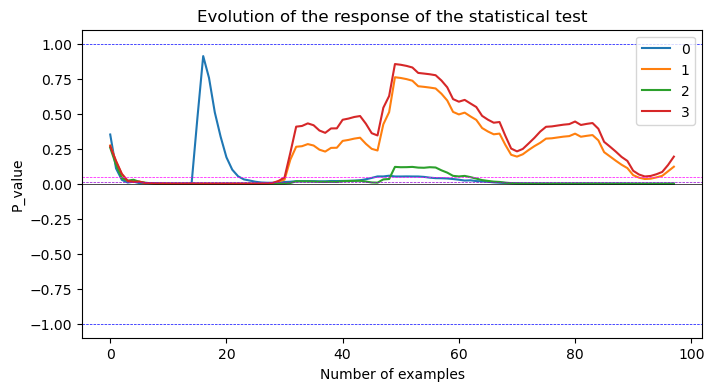

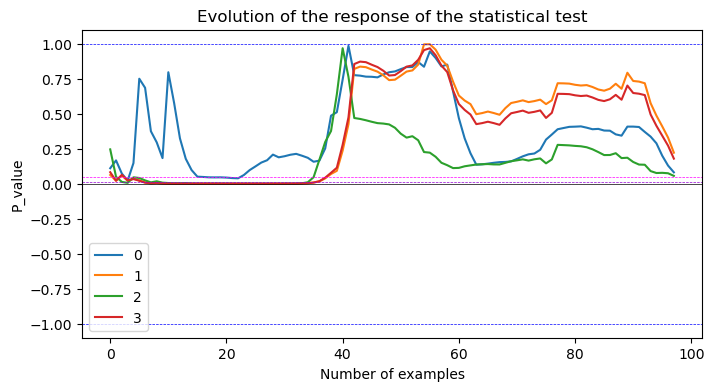

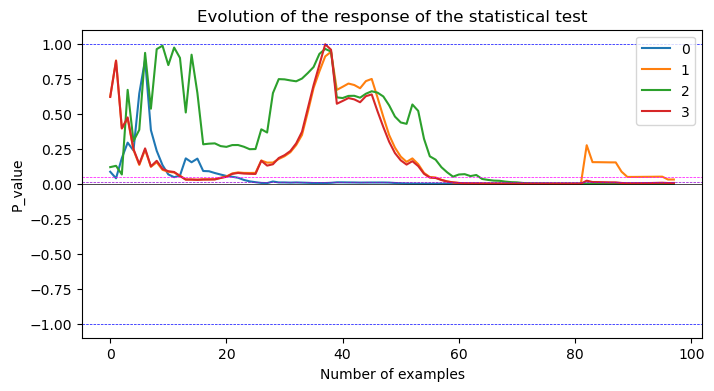

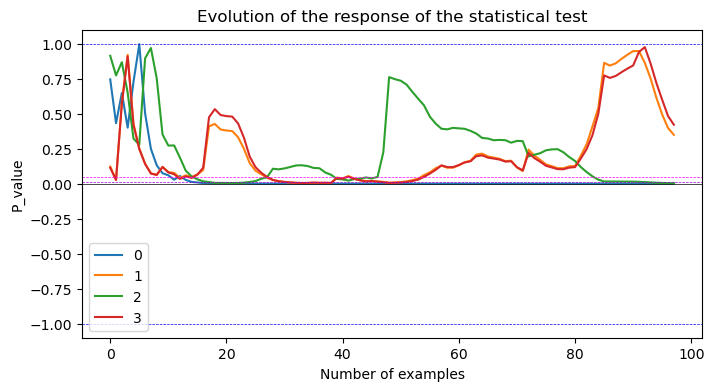

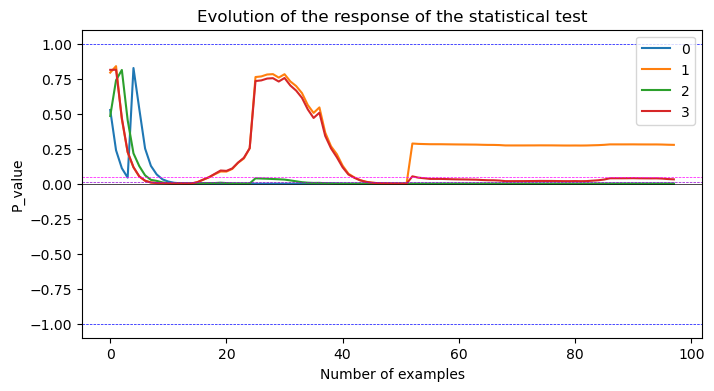

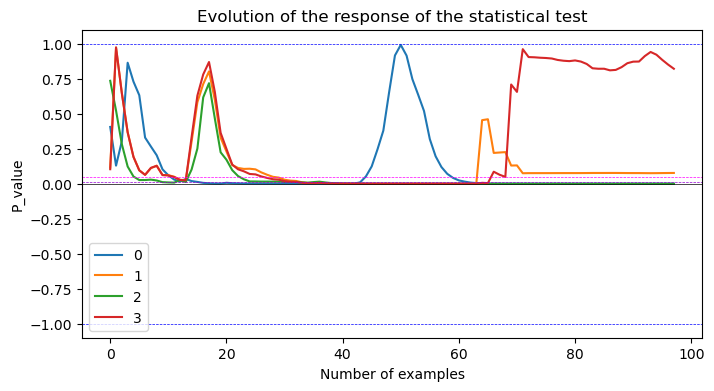

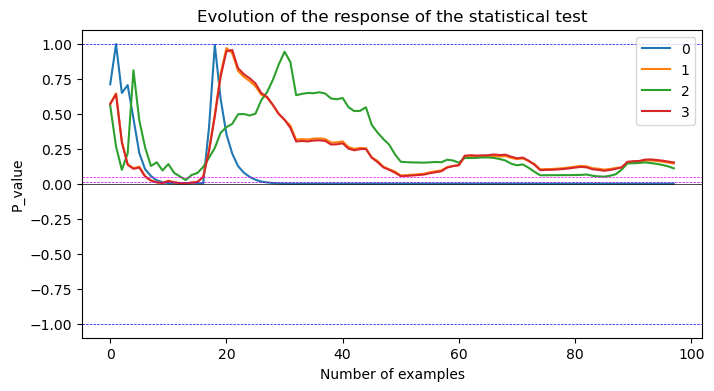

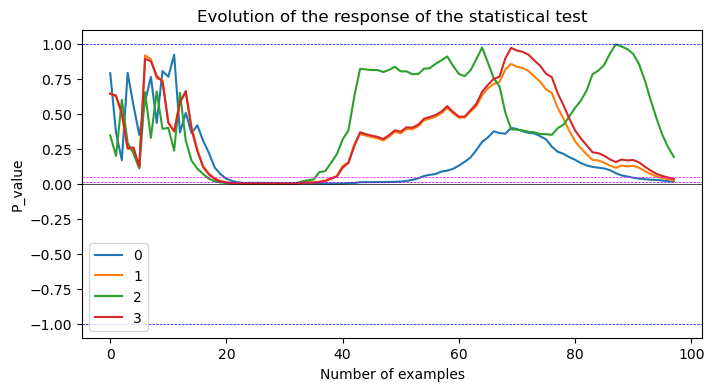

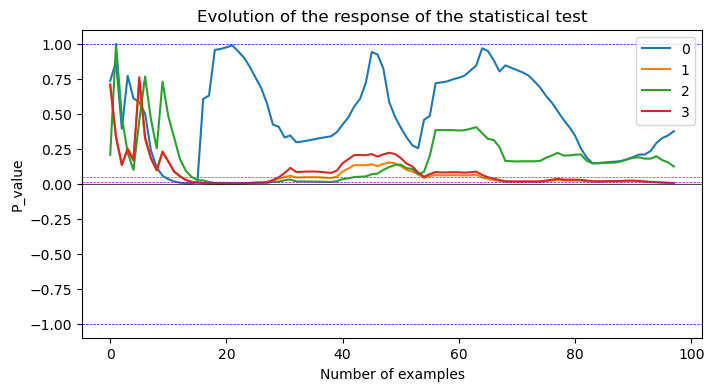

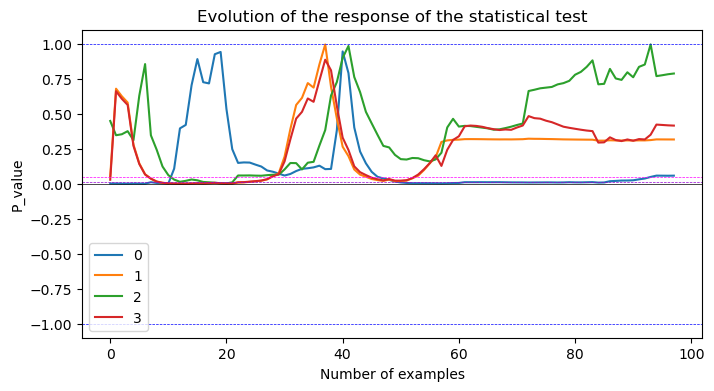

In [24]:
def detect_ood(nb_ep = 100,state_size = 4,action_size = 1,memory_size = 10):
    input_size = memory_size*(state_size+action_size)

    env = instanciate_cartpole(default_values)
    env = Memory(env, memory_size)
    observation = env.reset()

    pbar = trange(nb_ep)
    res = []
    real_errors = []
    pred_errors = []
    pred_diffs = []
    
    terminated=False
    observation = env.reset()

    for t in pbar:
        
        #real_diffs = []
        #pred_diffs = []
        

        action = env.action_space.sample()
        previous_obs = observation
        observation, reward, terminated, info = env.step(action)
        history = env.get_history(True).reshape(input_size)

        real_diff = np.array(observation-previous_obs)
        pred_diff = pred_model.predict(history[None,:])[0]
        pred_error = conf_model.predict(history[None,:])[0]
        #real_diffs.append(real_diff)
        pred_diffs.append(pred_diff)
        real_error = real_diff - pred_diff
        real_errors.append(real_error)

        pred_errors.append(pred_error)

        if terminated:
            observation = env.reset()
        """
        print(real_diff)
        print(pred_diff)
        print(err_pred)
        print()
        """
    pred_diffs = np.array(pred_diffs)
    real_errors = np.array(real_errors)
    pred_errors = np.array(pred_errors)
    #print(err_preds)
    evol_test(real_errors, path/'Plots')
    
    print(real_errors[0], pred_errors[0])
    res.append(corrected_test(real_errors, pred_errors))
    #res.append(z_test(err_preds))

    return np.array(res)

for i in range(10):
    detect_ood() #.mean(axis=0)

In [26]:
def compute_p_values(X):
    """
    p_value for the normal distribution
    X is supposed to be normalized
    """
    t = - np.abs(X)
    p_value = 2.0 * stats.norm.cdf(t)
    return p_value

def martingale(p_values):
        func = lambda x : np.prod(x * (p_values ** (x-1)))
        result = integrate.quad(func, 0, 1)
        return result[0]

In [43]:
martingale(np.random.rand(100))

0.1671104489425826

In [48]:
X_test, y_test = create_dataset(nb_steps=1000)
losses = pred_model.predict(X_test) - y_test
pred_std = conf_model.predict(X_test)

100%|██████████| 1000/1000 [00:00<00:00, 39119.40it/s]


In [51]:
losses/pred_std

array([[ 2.64823264e+00, -4.64447103e+00, -8.34671740e-01,
        -4.42507828e+00],
       [ 2.14535406e+00,  2.44076489e+00,  4.62927850e+00,
         2.41517325e+00],
       [ 2.88191836e+00,  5.07771338e+00, -1.04970331e+00,
         4.42089116e+00],
       ...,
       [-1.57267161e+00, -2.81650754e+00, -6.48191188e+00,
        -2.82902890e+00],
       [-2.66303069e+00, -1.05014584e+01,  1.41753536e+03,
        -9.77196237e+00],
       [ 4.72481470e+00, -1.16748385e+00,  1.21893215e+00,
        -1.16943585e+00]])

In [50]:
compute_p_values(losses/pred_std).mean()

0.23629752133516047

In [52]:
compute_p_values(losses/pred_std).std()

0.3063376378631038

In [54]:
(losses / losses.std()).mean()

0.01793508518851715

In [56]:
p_values = compute_p_values(losses/losses.std()).mean()

In [57]:
martingale(p_values)

0.5167815251459363

In [62]:
martingale(np.ones(1000))

0.0009990009990010233

In [61]:
np.abs(pred_std).min()

3.095716238022745e-08

In [58]:
martingale(compute_p_values(losses/pred_std))

/var/folders/bs/0f5dcrc501sf9wtpqltg62940000gn/T/ipykernel_50987/120546041.py:11: RuntimeWarning: divide by zero encountered in power
  func = lambda x : np.prod(x * (p_values ** (x-1)))


inf

In [47]:
losses

array([[-2.43607908e-05, -3.54349613e-05, -4.32439148e-05,
         7.57235289e-04],
       [ 3.63549218e-05, -3.22967768e-05, -7.92618841e-05,
         7.43108988e-04],
       [-1.02528930e-04,  8.50260258e-06, -4.82421368e-05,
        -1.94638968e-04],
       ...,
       [ 2.60685384e-04, -1.16193295e-04, -1.38378143e-04,
         2.46697664e-03],
       [-4.75350022e-04, -2.38415599e-04,  5.51779568e-04,
         5.05912304e-03],
       [-3.48223746e-04, -2.41929293e-04,  6.30871952e-04,
         5.02209961e-03]])

In [93]:

class MartingaleOODDetector():
    def __init__(self, env: gym.Env, verbose=True, *args, **kwargs) -> None:

        self.verbose = verbose

        # training the model
        X_pred, y_pred = create_dataset(env, nb_steps=10000)
        self.pred_model = MultiOutputRegressor(KNeighborsRegressor()).fit(X_pred, y_pred)
        #self.conf_model = conf_model

        in_distrib_score = self.test_ood(env)

        self.anomaly_threshold = 2.0*in_distrib_score

        if self.verbose:
            print("Anomaly score of the training distribution: ", in_distrib_score)

    def test_ood(self, env, nb_steps=1000):
        X_val, y_val = create_dataset(env, nb_steps)
        errors = np.abs((self.pred_model.predict(X_val) - y_val))

        if self.verbose:
            print("Absolute error")
            print("Mean: ", errors.mean())
            print("Std: ", errors.std())
            print()


        # Calibration of the ood detector
        ood_score = martingale(compute_p_values(errors/errors.std()))   
        print("corrected score ", np.log10(ood_score)/nb_steps)
        return ood_score


    def save(self, path):
        np.save(path / 'nonconformity_scores.npy', self.nonconformity_scores)
        
    def load(self, path):
        self.nonconformity_scores = np.load(path / 'nonconformity_scores.npy')

env = instanciate_cartpole(default_values)
ood_detector = MartingaleOODDetector(env)



100%|██████████| 1000/1000 [00:00<00:00, 44586.58it/s]

Absolute error
Mean:  0.01951194584664554
Std:  0.049224885980282025

corrected score  -0.0029459858021356313
Anomaly score of the training distribution:  0.0011324373840365237


In [94]:
default_values, values = get_cartpole_values()
ood_config = get_ood_configs(default_values, values)[-1]
ood_env = instanciate_cartpole(ood_config)
ood_config

{'Gravity': 9.8,
 'Mass_cart': 1.0,
 'Length_pole': 0.5,
 'Mass_pole': 0.1,
 'Force_magnitude': 100.0,
 'change': 'Force_magnitude'}

In [103]:
ood_detector.test_ood(ood_env, nb_steps=10)

100%|██████████| 10/10 [00:00<00:00, 8992.93it/s]

Absolute error
Mean:  1.134355851302389
Std:  1.1465708175281342

corrected score  0.12449979530933417


17.57915328573498

In [13]:
class NearestNeighborModel():
    def __init__(self, env, size_memory=5, confidence=True) -> None:
        self.size_memory = size_memory
        
        self.obs_limits = get_space_limits(env.observation_space)  
        self.act_limits = get_space_limits(env.action_space)
        
        self.state_size = self.obs_limits[0].shape[0]
        self.action_size = self.act_limits[0].shape[0]
        
        input_size, output_size = size_memory*(self.state_size + self.action_size), self.state_size
        
        #self.pred_model = MLP(input_size, output_size, size_hidden_layers, bias=True, final_activation=None, dropout=dropout)
        self.pred_model = 
        self.confidence = confidence
        if self.confidence:
            # nn.LeakyReLU has the advantage to have a symetrical derivative in any point excpet 0.
            # using for example the Softplus function would bias the variance estimation, and be problematic with the test
            self.conf_model = MLP(input_size, output_size, size_hidden_layers=[500, 100], bias=True, final_activation=nn.LeakyReLU(-1.0), dropout=dropout)

        #self.history_size = history_size
        self.criterion = nn.MSELoss()

    def predict_diff_states(self, history):
        X = torch.tensor(history).reshape(self.size_memory*(self.state_size+self.action_size)).float()  

        X.requires_grad = True
        pred_diff = self.pred_model(X) #.detach() 
        
        if self.confidence:
            std = self.conf_model(X) #.detach()
        else:
            std = torch.ones(pred_diff.shape).to(device)
        
        return pred_diff[0], std[0]

    def save(self, folder):
        os.makedirs(folder, exist_ok=True)
        torch.save(self.pred_model.cpu(), folder / 'pred_model.pth')
        if self.confidence:
            torch.save(self.conf_model.cpu(), folder / 'conf_model.pth')
        #joblib.dump(self.scaler_X, folder / 'scaler_X.bin', compress=True)
        #joblib.dump(self.scaler_Y, folder / 'scaler_Y.bin', compress=True)

    def load(self, folder):
        self.pred_model = torch.load(folder / 'pred_model.pth').to(device)
        if self.confidence:
            self.conf_model = torch.load(folder / 'conf_model.pth').to(device)
        #self.scaler_X = joblib.load(folder / 'scaler_X.bin')
        #self.scaler_Y = joblib.load(folder / 'scaler_Y.bin')


    def fit(self, env, nb_steps = 1000, num_epochs=25, lr :float =0.1):
        
        env = Memory(env, self.size_memory)
        models = {'pred':self.pred_model}
        if self.confidence:
            models['conf'] = self.conf_model
  
        for model_type, model in models.items():
            print('Fitting '+model_type+' : ' + str(model))
            model.train()

            # Observe that all parameters are being optimized
            optimizer = torch.optim.Adam(model.parameters(), lr)

            # Decay LR by a factor of 0.1 every 7 epochs
            scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

            writer = SummaryWriter('tensorboard/model_learning_'+model_type)
            since = time.time()

            best_loss = 1e10

            pbar = trange(num_epochs)
            for epoch in pbar:
                #print(f'Epoch {epoch}/{num_epochs - 1}')
                #print('-' * 10)

                # Each epoch has a training and validation phase
                phase_loss = {}
                    
                observation = env.reset()
                running_loss = 0.0
                
                for t in range(nb_steps):
                    #action, _state = agent.predict(observation)
                    action = env.action_space.sample()
                    previous_obs = observation
                    observation, reward, terminated, info = env.step(action)
                    history = env.get_history(True)
                    
                    observation = torch.FloatTensor(observation).reshape(self.state_size)     
                    #history = torch.FloatTensor(history).reshape(self.size_memory*self.state_size)     
                    #env.render()

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(True):
                        #print('inputs: ', inputs.shape)
                        #gap = (observation - previous_obs - pred_diff)/std
                        pred_diff, std = self.predict_diff_states(history)

                        if model_type == 'conf':
                            #print(observation, previous_obs, pred_diff)
                            loss = self.criterion(torch.abs(observation - previous_obs - pred_diff.detach()), std)
                            #loss = self.criterion((outputs - labels)**2, vari)
                        else:
                            loss = self.criterion((observation - previous_obs - pred_diff), torch.zeros(1)) #/std.detach()

                        loss.backward()
                        optimizer.step()

                        # statistics
                        running_loss += loss.item()
                        
                    if terminated:
                        observation = env.reset()
                        
                    
                scheduler.step()

                epoch_loss = running_loss / nb_steps
                    #print(f'{phase} Loss: {epoch_loss:.4f}')
                    #print()

                    # deep copy the model
                if epoch_loss < best_loss:
                    best_loss = epoch_loss

                writer.add_scalar(model_type+' Loss', epoch_loss, epoch)
                writer.flush()
                
                pbar.set_description("Loss: %2.4f" % (epoch_loss))

            time_elapsed = time.time() - since
            print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
            print(f'Best val Loss: {best_loss:4f}')

            
            model.eval()
            
        return best_loss

    def visualize(self, env, steps=100, saving_path=Path.cwd() / 'Plots', plot=True, render=False, figsize=(10, 4), dpi=300):
        env = Memory(env, self.size_memory)
        os.makedirs(saving_path, exist_ok=True)
        writer = SummaryWriter('tensorboard/visualize_model')
        
        self.pred_model = self.pred_model.to(device).eval()
        if self.confidence:
            self.conf_model = self.conf_model.to(device).eval()
        
        observations = []
        actions = []
        pred_diffs = []
        real_diffs = []
        pred_stds = []

        done=True

        if plot:
            pbar = trange(steps)
        else:
            pbar = range(steps)

        observation = torch.FloatTensor(env.reset()).reshape(self.state_size)     
        running_loss = 0.0

        for t in pbar:
            #action, _state = agent.predict(observation)
            action = env.action_space.sample()
            previous_obs = observation
            observation, reward, terminated, info = env.step(action)
            
            history = env.get_history(True)
            
            observation = torch.FloatTensor(observation).reshape(self.state_size)  
            if render:
                env.render()


            #print('inputs: ', inputs.shape)
            #gap = (observation - previous_obs - pred_diff)/std
            pred_diff, std = self.predict_diff_states(history)
            #pred_diff, std = self.predict_diff_states(previous_obs, action)
            pred_diff, std = pred_diff.detach(), std.detach()


            loss_conf = self.criterion(torch.abs(observation - previous_obs - pred_diff), std)

            loss_pred = self.criterion((observation - previous_obs - pred_diff)/std, torch.zeros(1))

            # statistics
            #running_loss += loss.item()

            if terminated:
                observation = env.reset()

            if plot:
                pbar.set_description("loss_pred: %2.4f, loss_conf: %2.4f" % (loss_pred, loss_conf))



            #print(f'{phase} Loss: {epoch_loss:.4f}')
            #print()
            #writer.add_scalars('run_14h', {'xsinx':np.sin(t), 'xcosx':np.cos(t), 'tanx': np.tan(t)}, t)
            for state_id in range(self.state_size):
                writer.add_scalar('observation/'+str(state_id), np.array(observation)[state_id], t)
                d =  {'predicted': np.array(pred_diff)[state_id], 'real': (np.array(observation) - np.array(previous_obs))[state_id]}

                writer.add_scalars('observation_difference/'+str(state_id),d, t)
                
                writer.add_scalar('observation_std/'+str(state_id), np.array(std)[state_id], t)

            for action_id in range(self.action_size):
                writer.add_scalar('action/'+str(action_id), np.array(action).reshape(self.action_size)[action_id], t)
                
            writer.flush()
            
            observations.append(np.array(observation)) #.numpy()
            actions.append(np.array(action).reshape(self.action_size))
            pred_diffs.append(np.array(pred_diff))
            real_diffs.append(np.array(observation) - np.array(previous_obs))
            pred_stds.append(np.array(std))

            """writer.add_scalar('state/'+str(state_id), distance.numpy(), i)
            writer.add_scalar('state/speed', speed.numpy(), i)
            writer.add_scalar('action', action.numpy(), i)
            writer.add_scalar('diff_distances/prediction', pred_diff_distance.numpy(), i)
            writer.add_scalar('diff_distances/reality', pred_diff_distance.numpy(), i)
            writer.add_scalar('diff_distances/variance', var_distance.numpy(), i)

            writer.add_scalar('diff_speed/prediction', pred_diff_speed.numpy(), i)
            writer.add_scalar('diff_speed/reality', real_diff_speed.numpy(), i)
            writer.add_scalar('diff_speed/variance', var_speed.numpy(), i)
            writer.flush()"""
            
        observations = np.array(observations)
        actions = np.array(actions)
        pred_diffs = np.array(pred_diffs)
        real_diffs = np.array(real_diffs)
        pred_stds = np.array(pred_stds)
        
        for state_id in range(self.state_size):
            

            evolution = {}
            evolution['prediction'] = np.array(pred_diffs[:,state_id])
            evolution['reality'] = np.array(real_diffs[:,state_id])
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of observation component ' + str(state_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_diff_obs', bbox_inches='tight')
                plt.show()
                
        for state_id in range(self.state_size):
            

            evolution = {}
            evolution['prediction'] = np.array(pred_diffs[:,state_id]) + observations
            evolution['reality'] = np.array(real_diffs[:,state_id]) + observations
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of observation component ' + str(state_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_diff_obs', bbox_inches='tight')
                plt.show()

        for action_id in range(self.action_size):
            
            evolution = {}
            evolution['prediction'] = np.array(actions[:,action_id])
            evolution['reality'] = np.array(actions[:,action_id])
            evolution_df = pd.DataFrame(data=evolution)
            if plot:
                fig = plt.figure(dpi=dpi, figsize=figsize) 
                evolution_df.plot(title='Evolution of the differences of action component ' + str(action_id), ax = plt.gca())
                #plt.ylabel('Distance (m)')
                plt.xlabel('Steps')
                plt.savefig(saving_path / 'evol_act', bbox_inches='tight')
                plt.show()

        

        """
        error_diff_distances = diff_distance_dict['prediction'] - diff_distance_dict['reality']
        if plot:
            plot_error_variance(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, unit='m')
            plot_error_corrected(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, dpi=dpi)
            plot_error_confidence_from_variance(error_diff_distances, var_distances, saving_path, 'distance', figsize=figsize, dpi=dpi, unit='m')

        error_diff_speeds = diff_speed_dict['prediction'] - diff_speed_dict['reality']
        if plot:
            plot_error_variance(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, unit='m/s')
            plot_error_corrected(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, dpi=dpi)
            plot_error_confidence_from_variance(error_diff_speeds, var_speeds, saving_path, 'speed', figsize=figsize, dpi=dpi, unit='m/s')
        """
        return observations, actions, pred_diffs, real_diffs, pred_stds


SyntaxError: invalid syntax (3554275634.py, line 14)

In [2]:
nb_threshold = 5
for threshold in [2**(-i) for i in range(1, nb_threshold+1)]:
    print(threshold)

0.5
0.25
0.125
0.0625
0.03125
